# Feature Selection

## Optimizing VALUE
### Utilizing IG
For datasets with entirely categorical features, Information Gain (IG) is often the better choice.
Information Gain directly computes entropy and conditional entropy values, making it inherently suited for categorical variables without needing complex estimators. It naturally handles categorical splits, aligning with how information gain is used in decision trees and rule-based methods.

In [1]:
import pandas as pd
import numpy as np

from ucimlrepo import fetch_ucirepo
from scipy.stats import entropy

In [2]:
def entropy(counts):
    """
    Calculate the entropy of a set of counts.
    """
    probabilities = counts / np.sum(counts)
    return -np.sum(probabilities * np.log2(probabilities + 1e-10))  # Adding small value to avoid log(0)

def information_gain(X, y, feature):
    """
    Calculate the information gain of a categorical feature with respect to the target variable y.
    """
    y = np.array(y).flatten()
    y = (y == 1).astype(int)
    
    total_entropy = entropy(np.bincount(y))
    
    values, counts = np.unique(X[feature], return_counts=True)
    conditional_entropy = 0
    for value, count in zip(values, counts):
        y_given_x = y[X[feature] == value]
        conditional_entropy += (count / len(X)) * entropy(np.bincount(y_given_x))
    return total_entropy - conditional_entropy

In [3]:
phishing_websites = fetch_ucirepo(id=327)
X = phishing_websites.data.features
y = phishing_websites.data.targets

In [4]:
print("All features:")
for feature in X.columns:
    print(feature)

All features:
having_ip_address
url_length
shortining_service
having_at_symbol
double_slash_redirecting
prefix_suffix
having_sub_domain
sslfinal_state
domain_registration_length
favicon
port
https_token
request_url
url_of_anchor
links_in_tags
sfh
submitting_to_email
abnormal_url
redirect
on_mouseover
rightclick
popupwindow
iframe
age_of_domain
dnsrecord
web_traffic
page_rank
google_index
links_pointing_to_page
statistical_report


In [5]:
filter_out_list = [
    'sslfinal_state',
    'https_token',
    'having_ip_address',
    'url_length',
] 

# Filter out the features from X
X = X.drop(columns=filter_out_list)

In [6]:
ig_values = {feature: information_gain(X, y, feature) for feature in X.columns}
ig_values = sorted(ig_values.items(), key=lambda item: item[1], reverse=True)

In [7]:
def rank_features_by_ig(ig_values):
    return sorted(ig_values.items(), key=lambda item: item[1], reverse=True)

ranked_features = rank_features_by_ig(dict(ig_values))

print("Ranked features based on Information Gain:")
for rank, (feature, ig) in enumerate(ranked_features, start=1):
    print(f"{rank}. {feature}: {ig:.4f}")

Ranked features based on Information Gain:
1. url_of_anchor: 0.4773
2. prefix_suffix: 0.1234
3. web_traffic: 0.1146
4. having_sub_domain: 0.1097
5. links_in_tags: 0.0470
6. request_url: 0.0466
7. sfh: 0.0375
8. domain_registration_length: 0.0368
9. google_index: 0.0119
10. age_of_domain: 0.0107
11. page_rank: 0.0080
12. statistical_report: 0.0046
13. links_pointing_to_page: 0.0044
14. dnsrecord: 0.0041
15. shortining_service: 0.0034
16. abnormal_url: 0.0027
17. having_at_symbol: 0.0020
18. on_mouseover: 0.0013
19. double_slash_redirecting: 0.0011
20. port: 0.0010
21. redirect: 0.0003
22. submitting_to_email: 0.0002
23. rightclick: 0.0001
24. iframe: 0.0000
25. favicon: 0.0000
26. popupwindow: 0.0000


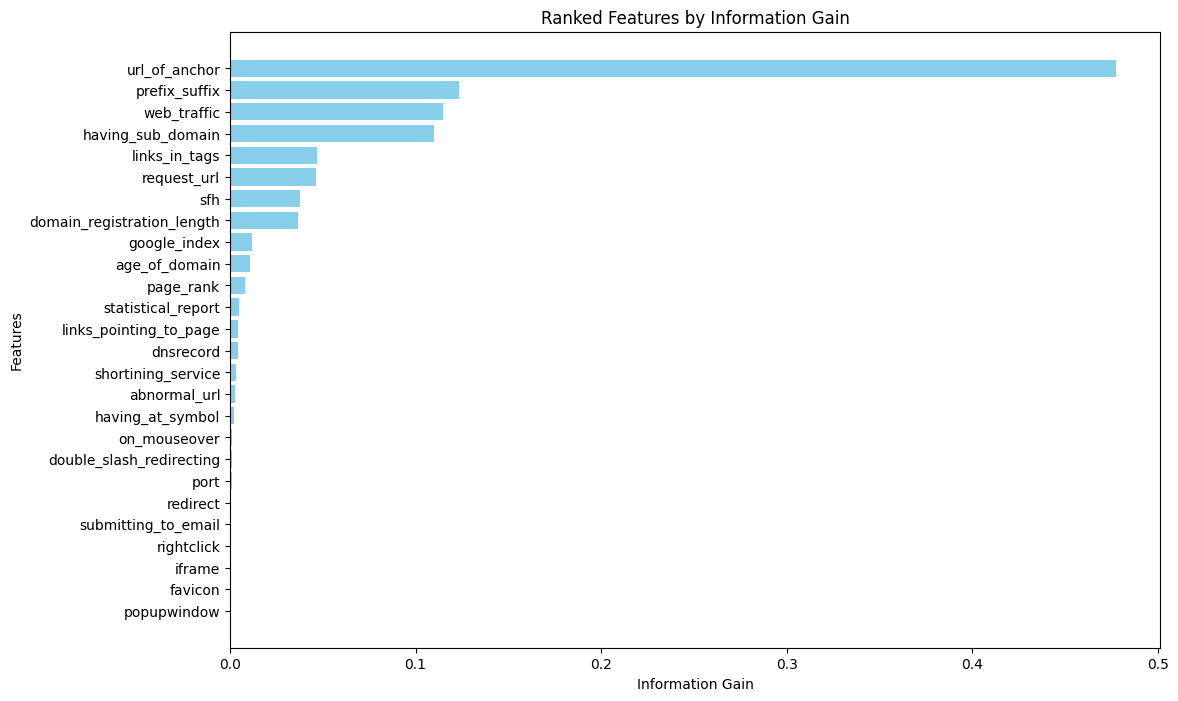

In [8]:
import matplotlib.pyplot as plt

features = [feature for feature, ig in ranked_features]
ig_values = [ig for feature, ig in ranked_features]

plt.figure(figsize=(12, 8))
plt.barh(features, ig_values, color='skyblue')
plt.xlabel('Information Gain')
plt.ylabel('Features')
plt.title('Ranked Features by Information Gain')
plt.gca().invert_yaxis()
plt.show()

In [8]:
def get_top_k_features(ig_values, k):
    return sorted(ig_values.items(), key=lambda item: item[1], reverse=True)[:k]

ig_values = {feature: information_gain(X, y, feature) for feature in X.columns}
ig_values = sorted(ig_values.items(), key=lambda item: item[1], reverse=True)
top_k_features = get_top_k_features(dict(ig_values), k=10)
print("Top 5 features based on Information Gain:")
for feature, ig in top_k_features:
    print(f"{feature}: {ig:.4f}")

Top 5 features based on Information Gain:
url_of_anchor: 0.4773
prefix_suffix: 0.1234
web_traffic: 0.1146
having_sub_domain: 0.1097
links_in_tags: 0.0470
request_url: 0.0466
sfh: 0.0375
domain_registration_length: 0.0368
google_index: 0.0119
age_of_domain: 0.0107


## Optimizing TIME
### Weights decided based on the time required to calculate each feature in a live setting

In [9]:
import json

def read_json_to_dict(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

In [10]:
data_dict = read_json_to_dict('../data/collected/time_data.json')
time_data = [value['Timing Data'] for value in data_dict]

df = pd.DataFrame(time_data)
average_values = df.mean()

times = pd.DataFrame(list(average_values.items()), columns=['feature', 'time'])

min_weight, max_weight = 0.1, 1.0

times['transformed_time'] = np.log1p(times['time'])

times['normalized_weight'] = 1 - (((times['transformed_time'] - times['transformed_time'].min()) /
                                   (times['transformed_time'].max() - times['transformed_time'].min())) * 
                                  (max_weight - min_weight) + min_weight)

time_costs = dict(zip(times['feature'], times['normalized_weight']))

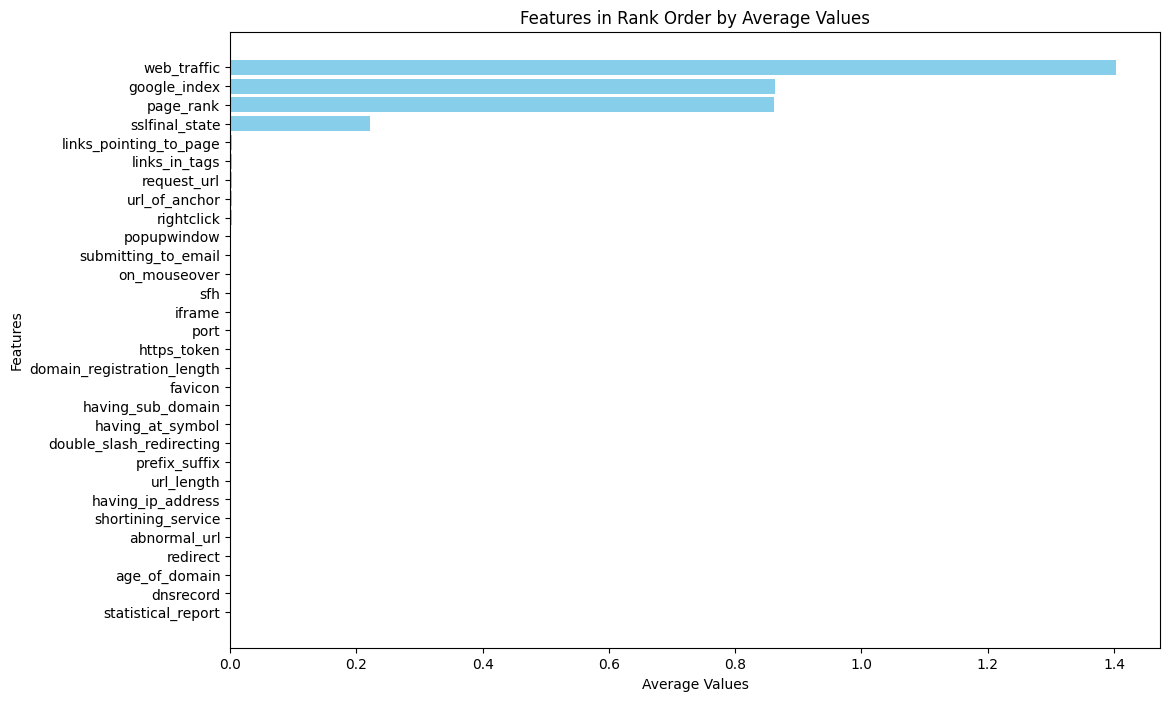

In [11]:
average_values_sorted = average_values.sort_values(ascending=False)
plt.figure(figsize=(12, 8))
plt.barh(average_values_sorted.index, average_values_sorted.values, color='skyblue')
plt.xlabel('Average Values')
plt.ylabel('Features')
plt.title('Features in Rank Order by Average Values')
plt.gca().invert_yaxis()
plt.show()

In [12]:
w_IG = 0.8
w_TC = 0.2


In [13]:
composite_scores = {}
ig_values = {feature: information_gain(X, y, feature) for feature in X.columns}
ig_values = sorted(ig_values.items(), key=lambda item: item[1], reverse=True)
ranked_features = rank_features_by_ig(dict(ig_values))

for feature, ig in ranked_features:
    time_cost = time_costs.get(feature, 0.0)
    composite_score = w_IG * ig + w_TC * (1 + time_cost)
    composite_scores[feature] = composite_score

In [14]:
ranked_features = sorted(composite_scores.items(), key=lambda item: item[1], reverse=True)

print("Ranked Features Based on Composite Score (IG and Time Cost):")
for rank, (feature, score) in enumerate(ranked_features, start=1):
    print(f"{rank}. {feature}: {score:.4f}")

Ranked Features Based on Composite Score (IG and Time Cost):
1. url_of_anchor: 0.7613
2. prefix_suffix: 0.4787
3. having_sub_domain: 0.4678
4. links_in_tags: 0.4170
5. request_url: 0.4167
6. sfh: 0.4099
7. domain_registration_length: 0.4094
8. age_of_domain: 0.3885
9. statistical_report: 0.3837
10. dnsrecord: 0.3833
11. links_pointing_to_page: 0.3828
12. shortining_service: 0.3827
13. abnormal_url: 0.3821
14. having_at_symbol: 0.3816
15. on_mouseover: 0.3809
16. double_slash_redirecting: 0.3809
17. port: 0.3808
18. redirect: 0.3802
19. favicon: 0.3800
20. iframe: 0.3800
21. submitting_to_email: 0.3799
22. rightclick: 0.3796
23. popupwindow: 0.3796
24. web_traffic: 0.2917
25. google_index: 0.2617
26. page_rank: 0.2587


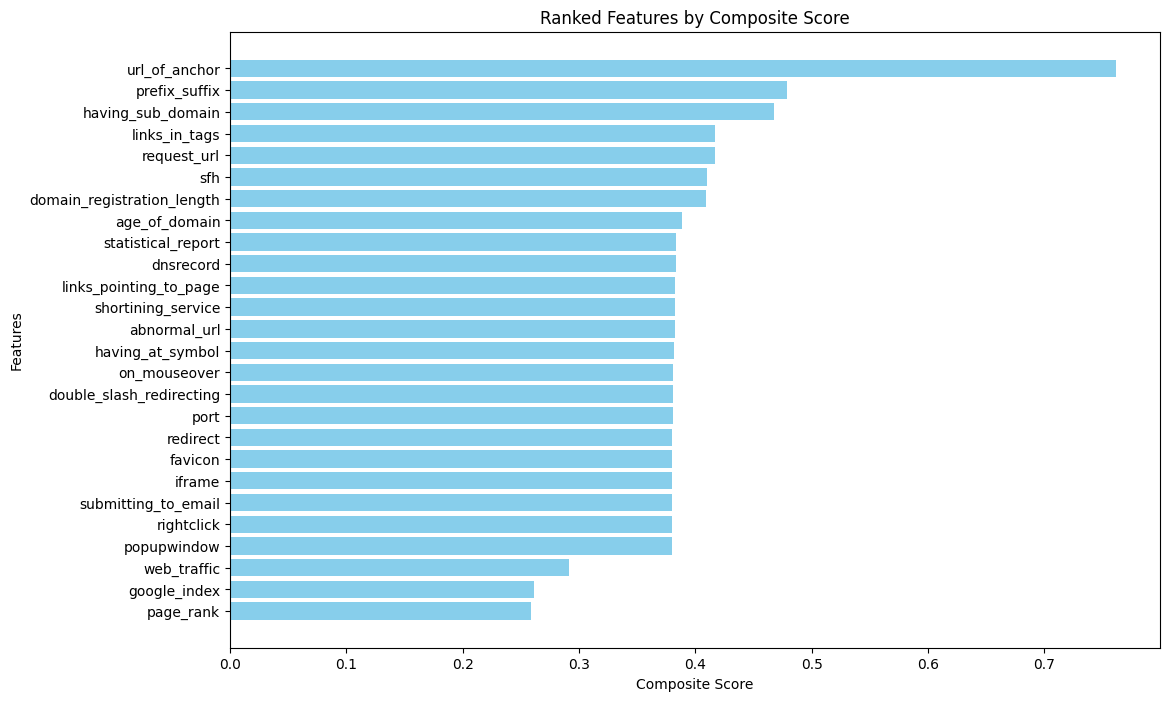

In [15]:
import matplotlib.pyplot as plt

features = [feature for feature, score in ranked_features]
composite_scores_values = [score for feature, score in ranked_features]

plt.figure(figsize=(12, 8))
plt.barh(features, composite_scores_values, color='skyblue')
plt.xlabel('Composite Score')
plt.ylabel('Features')
plt.title('Ranked Features by Composite Score')
plt.gca().invert_yaxis()
plt.show()

# Final Output

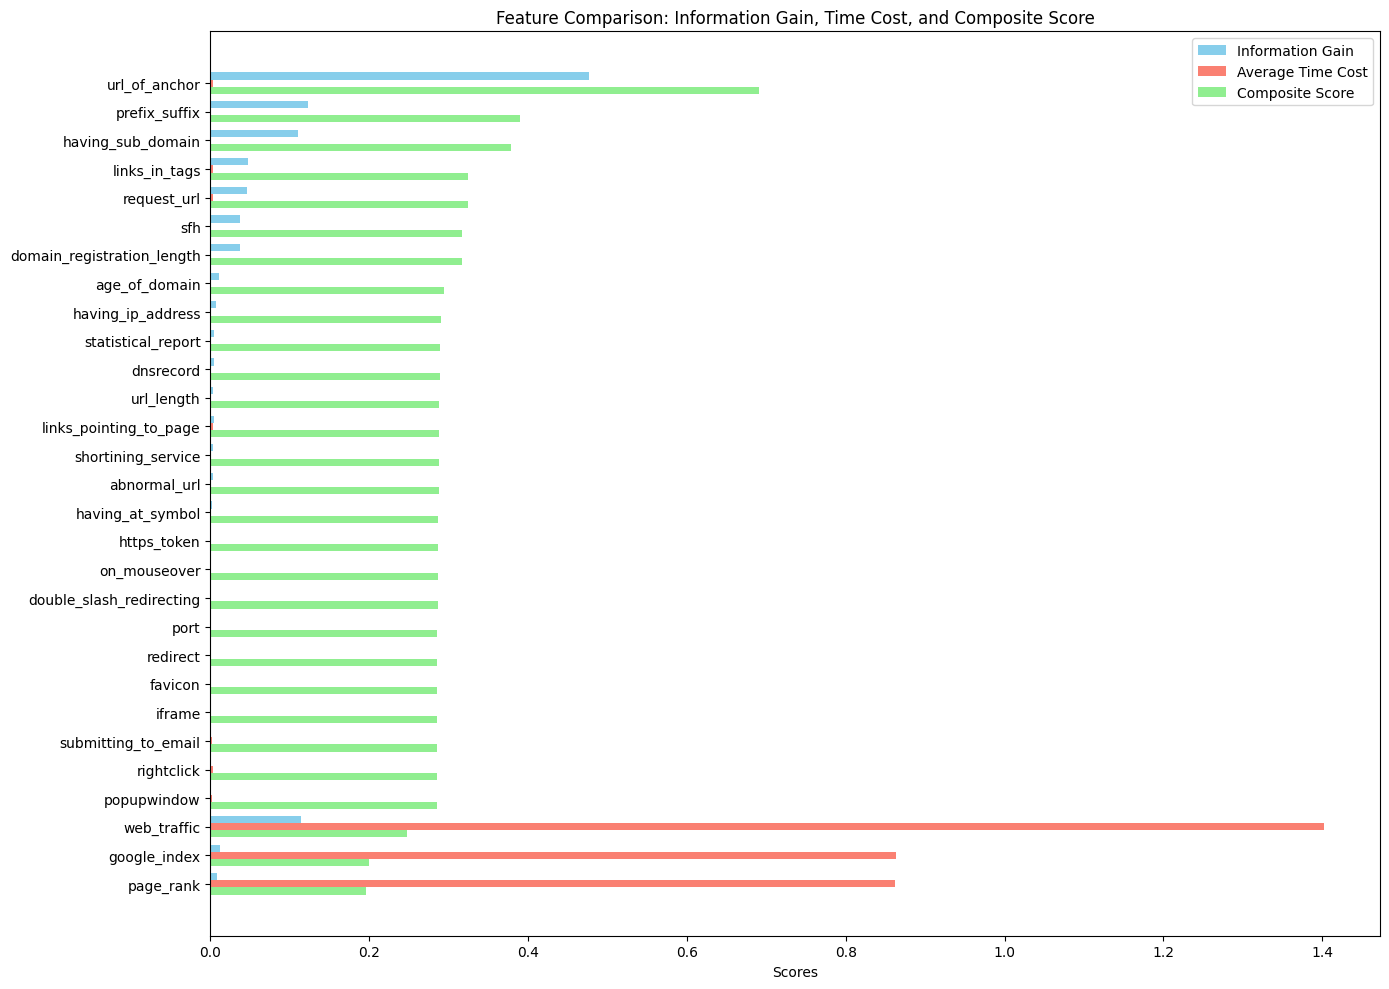

In [16]:
phishing_websites = fetch_ucirepo(id=327)
X = phishing_websites.data.features
y = phishing_websites.data.targets

filter_out_list = ['sslfinal_state'] 

# Filter out the features from X
X = X.drop(columns=filter_out_list)

ig_values = {feature: information_gain(X, y, feature) for feature in X.columns}
ig_values = sorted(ig_values.items(), key=lambda item: item[1], reverse=True)

data_dict = read_json_to_dict('../data/collected/time_data.json')
time_data = [value['Timing Data'] for value in data_dict]

df = pd.DataFrame(time_data)
average_values = df.mean()

times = pd.DataFrame(list(average_values.items()), columns=['feature', 'time'])

min_weight, max_weight = 0.1, 1.0

times['transformed_time'] = np.log1p(times['time'])

times['normalized_weight'] = 1 - (((times['transformed_time'] - times['transformed_time'].min()) /
                                   (times['transformed_time'].max() - times['transformed_time'].min())) * 
                                  (max_weight - min_weight) + min_weight)

time_costs = dict(zip(times['feature'], times['normalized_weight']))

composite_scores = {}
ranked_features = rank_features_by_ig(dict(ig_values))
w_IG = 0.85
w_TC = 0.15

for feature, ig in ranked_features:
    time_cost = time_costs.get(feature, 0.0)
    composite_score = w_IG * ig + w_TC * (1 + time_cost)
    composite_scores[feature] = composite_score

composite = sorted(composite_scores.items(), key=lambda item: item[1], reverse=True)

sorted_features = [feature for feature, score in composite]

ig_values_sorted = [dict(ranked_features).get(feature, 0) for feature in sorted_features]
time_cost_values_sorted = [average_values[feature] for feature in sorted_features]
composite_scores_sorted = [dict(composite).get(feature, 0) for feature in sorted_features]

bar_width = 0.25
x_positions = np.arange(len(sorted_features))

fig, ax = plt.subplots(figsize=(14, 10))

ax.barh(x_positions - bar_width, ig_values_sorted, height=bar_width, color='skyblue', label='Information Gain')

ax.barh(x_positions, time_cost_values_sorted, height=bar_width, color='salmon', label='Average Time Cost')

ax.barh(x_positions + bar_width, composite_scores_sorted, height=bar_width, color='lightgreen', label='Composite Score')

ax.set_yticks(x_positions)
ax.set_yticklabels(sorted_features)
ax.set_xlabel('Scores')
ax.set_title('Feature Comparison: Information Gain, Time Cost, and Composite Score')
ax.invert_yaxis()

ax.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [17]:
from tabulate import tabulate

ig_values = {feature: information_gain(X, y, feature) for feature in X.columns}
ig_values = sorted(ig_values.items(), key=lambda item: item[1], reverse=True)

data_dict = read_json_to_dict('../data/collected/time_data.json')
time_data = [value['Timing Data'] for value in data_dict]

df = pd.DataFrame(time_data)
average_values = df.mean()

times = pd.DataFrame(list(average_values.items()), columns=['feature', 'time'])

min_weight, max_weight = 0.1, 1.0

times['transformed_time'] = np.log1p(times['time'])

times['normalized_weight'] = 1 - (((times['transformed_time'] - times['transformed_time'].min()) /
                                   (times['transformed_time'].max() - times['transformed_time'].min())) * 
                                  (max_weight - min_weight) + min_weight)

time_costs = dict(zip(times['feature'], times['normalized_weight']))

composite_scores = {}
ranked_features = rank_features_by_ig(dict(ig_values))
w_IG = 0.85
w_TC = 0.15

for feature, ig in ranked_features:
    time_cost = time_costs.get(feature, 0.0)
    composite_score = w_IG * ig + w_TC * (1 + time_cost)
    composite_scores[feature] = composite_score

composite = sorted(composite_scores.items(), key=lambda item: item[1], reverse=True)
ig_values = dict(ig_values)
composite = dict(composite)

# Extract top 10 features based on IG
top_15_ig_features = sorted(ig_values.items(), key=lambda item: item[1], reverse=True)[:20]

# Extract top 10 features based on composite scores
top_15_composite_features = sorted(composite.items(), key=lambda item: item[1], reverse=True)[:20]

# Create a table
table_data = []
for i in range(20):
    ig_feature, ig_value = top_15_ig_features[i]
    composite_feature, composite_value = top_15_composite_features[i]
    table_data.append([i+1, ig_feature, ig_value, composite_feature, composite_value])

# Define table headers
headers = ["Rank", "Top 20 IG Features", "IG Value", "Top 20 Composite Features", "Composite Score"]

# Print the table
print(tabulate(table_data, headers=headers, tablefmt="fancy_grid"))

╒════════╤════════════════════════════╤════════════╤═════════════════════════════╤═══════════════════╕
│   Rank │ Top 20 IG Features         │   IG Value │ Top 20 Composite Features   │   Composite Score │
╞════════╪════════════════════════════╪════════════╪═════════════════════════════╪═══════════════════╡
│      1 │ url_of_anchor              │ 0.477303   │ url_of_anchor               │          0.690293 │
├────────┼────────────────────────────┼────────────┼─────────────────────────────┼───────────────────┤
│      2 │ prefix_suffix              │ 0.123432   │ prefix_suffix               │          0.389917 │
├────────┼────────────────────────────┼────────────┼─────────────────────────────┼───────────────────┤
│      3 │ web_traffic                │ 0.114592   │ having_sub_domain           │          0.378275 │
├────────┼────────────────────────────┼────────────┼─────────────────────────────┼───────────────────┤
│      4 │ having_sub_domain          │ 0.109735   │ links_in_tags       

In [18]:
import json

features = {
    "IG": [feature for feature, _ in top_15_ig_features],
    "Comp": [feature for feature, _ in top_15_composite_features]
}
with open('../configs/features/features_20.json', 'w') as file:
    json.dump(features, file, indent=4)